# Lenta Uplift Modeling Dataset

Lenta is a russian food retailer.

Lenta dataset for uplift modeling contains data about Lenta's customers grociery shopping and related marketing campaigns. 

The dataset was originally released for the [BIGTARGET Hackathon by LENTA and Microsoft](https://bigtarget.online/) and is accessible from `sklift.datasets` module using `fetch_lenta` function.

Read more about dataset <a href="https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html">in the api docs</a>.

## Load Lenta dataset

In [ ]:
import sys

# install uplift library scikit-uplift and other libraries 
!{sys.executable} -m pip install scikit-uplift catboost scikit-learn seaborn matplotlib pandas numpy

In [33]:
from sklift.datasets import fetch_lenta
from sklift.models import ClassTransformation
from sklift.metrics import uplift_at_k
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

%matplotlib inline

In [2]:
# returns sklearn Bunch object
# with data, target, treatment keys
# data features (pd.DataFrame), target (pd.Series), treatment (pd.Series) values 
dataset = fetch_lenta()

print(f"Dataset type: {type(dataset)}\n")
print(f"Dataset features shape: {dataset.data.shape}")
print(f"Dataset target shape: {dataset.target.shape}")
print(f"Dataset treatment shape: {dataset.treatment.shape}")

dataset.keys()

Dataset type: <class 'sklearn.utils.Bunch'>

Dataset features shape: (687029, 193)
Dataset target shape: (687029,)
Dataset treatment shape: (687029,)


dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

Dataset is a dictionary-like object with the following attributes:
* ``data`` (DataFrame object): Dataset without target and treatment.
* ``target`` (Series object): Column target by values.
* ``treatment`` (Series object): Column treatment by values.
* ``DESCR`` (str): Description of the Lenta dataset.
* ``feature_names`` (list): Names of the features.
* ``target_name`` (str): Name of the target.
* ``treatment_name`` (str): Name of the treatment.
                
**Major columns:**
- treatment `group` (str): test/control group flag
- target `response_att` (binary): target
- data `gender` (str): customer gender
- data `age` (float): customer age
- data `main_format` (int): store type (1 - grociery store, 0 - superstore)

Detailed feature description could be found [here](https://www.uplift-modeling.com/en/latest/api/datasets/fetch_lenta.html#lenta).

We can specify the path to the destination folder and the name of the folder where the dataset should be stored with `data_home` and `dest_subdir` parameters. By default the path is `/`.

In [3]:
# data_home, dest_subdir = "/etc", "data"
# dataset = fetch_lenta(data_home=data_home, dest_subdir=dest_subdir)

We can load and return data, target, and treatment with setting the `return_X_y_t` parameter to `True`. By default `return_X_y_t=False`.

In [4]:
# data, target, treatment = fetch_lenta(return_X_y_t=True)

## Target share for `treatment / control` 

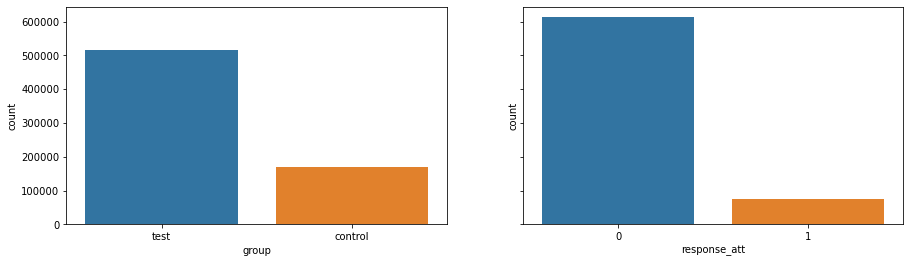

In [5]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,4))

treatment = dataset["treatment"]
target = dataset["target"]

sns.countplot(x=treatment, ax=ax[0])
sns.countplot(x=target, ax=ax[1])

The current sample is unbalanced in terms of both treatment and target.

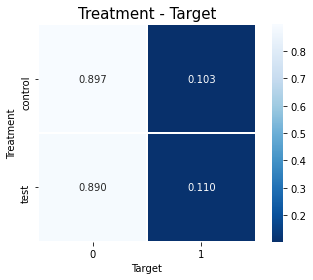

In [6]:
def crosstab_plot(treatment, target):
    ct = pd.crosstab(treatment, target, normalize='index')
    
    sns.heatmap(ct, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
    plt.ylabel('Treatment')
    plt.xlabel('Target')
    plt.title("Treatment - Target", size = 15)
    
crosstab_plot(dataset.treatment, dataset.target)

## Distributions of some features by treatment

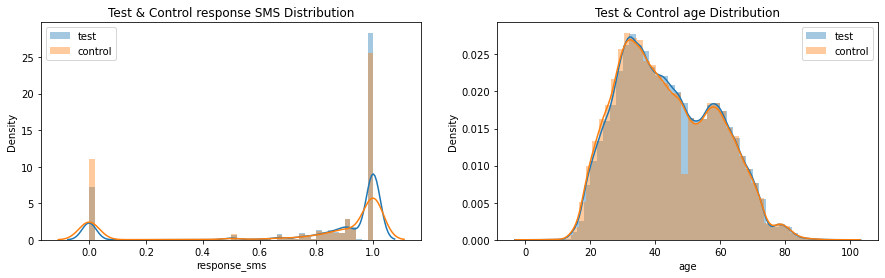

In [37]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

test_index = dataset.treatment[dataset.treatment == 'test'].index
control_index = dataset.treatment[dataset.treatment == 'control'].index

sns.distplot(dataset.data.loc[test_index, 'response_sms'], label='test', ax=ax[0])
sns.distplot(dataset.data.loc[control_index, 'response_sms'], label='control', ax=ax[0])
ax[0].title.set_text('Test & Control response SMS Distribution')
ax[0].legend()

sns.distplot(dataset.data.loc[test_index, 'age'], label='test', ax=ax[1])
sns.distplot(dataset.data.loc[control_index, 'age'], label='control', ax=ax[1])
ax[1].title.set_text('Test & Control age Distribution')
ax[1].legend()

Clients from the test treatment group tend to respond to sms with a slightly greater probability than clients from the control group. The behavior in the test and control groups does not differ depending on the clients age.

## Data analysys

In [8]:
dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 687029 entries, 0 to 687028
Columns: 193 entries, age to stdev_discount_depth_1m
dtypes: float64(191), int64(1), object(1)
memory usage: 1011.6+ MB


In [9]:
dataset.data.head().append(dataset.data.tail())

,age,cheque_count_12m_g20,cheque_count_12m_g21,cheque_count_12m_g25,cheque_count_12m_g32,cheque_count_12m_g33,cheque_count_12m_g38,cheque_count_12m_g39,cheque_count_12m_g41,cheque_count_12m_g42,cheque_count_12m_g45,cheque_count_12m_g46,cheque_count_12m_g48,cheque_count_12m_g52,cheque_count_12m_g56,cheque_count_12m_g57,cheque_count_12m_g58,cheque_count_12m_g79,cheque_count_3m_g20,cheque_count_3m_g21,cheque_count_3m_g25,cheque_count_3m_g42,cheque_count_3m_g45,cheque_count_3m_g52,cheque_count_3m_g56,cheque_count_3m_g57,cheque_count_3m_g79,cheque_count_6m_g20,cheque_count_6m_g21,cheque_count_6m_g25,cheque_count_6m_g32,cheque_count_6m_g33,cheque_count_6m_g38,cheque_count_6m_g39,cheque_count_6m_g40,cheque_count_6m_g41,cheque_count_6m_g42,cheque_count_6m_g45,cheque_count_6m_g46,cheque_count_6m_g48,cheque_count_6m_g52,cheque_count_6m_g56,cheque_count_6m_g57,cheque_count_6m_g58,cheque_count_6m_g79,children,crazy_purchases_cheque_count_12m,crazy_purchases_cheque_count_1m,crazy_purchases_cheque_count_3m,crazy_purchases_cheque_count_6m,crazy_purchases_goods_count_12m,crazy_purchases_goods_count_6m,disc_sum_6m_g34,food_share_15d,food_share_1m,gender,k_var_cheque_15d,k_var_cheque_3m,k_var_cheque_category_width_15d,k_var_cheque_group_width_15d,k_var_count_per_cheque_15d_g24,k_var_count_per_cheque_15d_g34,k_var_count_per_cheque_1m_g24,k_var_count_per_cheque_1m_g27,k_var_count_per_cheque_1m_g34,k_var_count_per_cheque_1m_g44,k_var_count_per_cheque_1m_g49,k_var_count_per_cheque_3m_g24,k_var_count_per_cheque_3m_g27,k_var_count_per_cheque_3m_g32,k_var_count_per_cheque_3m_g34,k_var_count_per_cheque_3m_g41,k_var_count_per_cheque_3m_g44,k_var_count_per_cheque_6m_g24,k_var_count_per_cheque_6m_g27,k_var_count_per_cheque_6m_g32,k_var_count_per_cheque_6m_g44,k_var_days_between_visits_15d,k_var_days_between_visits_1m,k_var_days_between_visits_3m,k_var_disc_per_cheque_15d,k_var_disc_share_12m_g32,k_var_disc_share_15d_g24,k_var_disc_share_15d_g34,k_var_disc_share_15d_g49,k_var_disc_share_1m_g24,k_var_disc_share_1m_g27,k_var_disc_share_1m_g34,k_var_disc_share_1m_g40,k_var_disc_share_1m_g44,k_var_disc_share_1m_g49,k_var_disc_share_1m_g54,k_var_disc_share_3m_g24,k_var_disc_share_3m_g26,k_var_disc_share_3m_g27,k_var_disc_share_3m_g32,k_var_disc_share_3m_g33,k_var_disc_share_3m_g34,k_var_disc_share_3m_g38,k_var_disc_share_3m_g40,k_var_disc_share_3m_g41,k_var_disc_share_3m_g44,k_var_disc_share_3m_g46,k_var_disc_share_3m_g48,k_var_disc_share_3m_g49,k_var_disc_share_3m_g54,k_var_disc_share_6m_g24,k_var_disc_share_6m_g27,k_var_disc_share_6m_g32,k_var_disc_share_6m_g34,k_var_disc_share_6m_g44,k_var_disc_share_6m_g46,k_var_disc_share_6m_g49,k_var_disc_share_6m_g54,k_var_discount_depth_15d,k_var_discount_depth_1m,k_var_sku_per_cheque_15d,k_var_sku_price_12m_g32,k_var_sku_price_15d_g34,k_var_sku_price_15d_g49,k_var_sku_price_1m_g24,k_var_sku_price_1m_g26,k_var_sku_price_1m_g27,k_var_sku_price_1m_g34,k_var_sku_price_1m_g40,k_var_sku_price_1m_g44,k_var_sku_price_1m_g49,k_var_sku_price_1m_g54,k_var_sku_price_3m_g24,k_var_sku_price_3m_g26,k_var_sku_price_3m_g27,k_var_sku_price_3m_g32,k_var_sku_price_3m_g33,k_var_sku_price_3m_g34,k_var_sku_price_3m_g40,k_var_sku_price_3m_g41,k_var_sku_price_3m_g44,k_var_sku_price_3m_g46,k_var_sku_price_3m_g48,k_var_sku_price_3m_g49,k_var_sku_price_3m_g54,k_var_sku_price_6m_g24,k_var_sku_price_6m_g26,k_var_sku_price_6m_g27,k_var_sku_price_6m_g32,k_var_sku_price_6m_g41,k_var_sku_price_6m_g42,k_var_sku_price_6m_g44,k_var_sku_price_6m_g48,k_var_sku_price_6m_g49,main_format,mean_discount_depth_15d,months_from_register,perdelta_days_between_visits_15_30d,promo_share_15d,response_sms,response_viber,sale_count_12m_g32,sale_count_12m_g33,sale_count_12m_g49,sale_count_12m_g54,sale_count_12m_g57,sale_count_3m_g24,sale_count_3m_g33,sale_count_3m_g57,sale_count_6m_g24,sale_count_6m_g25,sale_count_6m_g32,sale_count_6m_g33,sale_count_6m_g44,sale_count_6m_g54,sale_count_6m_g57,sale_sum_12m_g24,sale_sum_12m_g25,sale_sum_12m_g26,sale_sum_12m_g27,sale_sum_12m_

* There are 193 columns in the dataset
* The dataset contains: 
    - basic information about clients (age, number of children)
    - information about some groups of goods
    - statistical information (variation of discounts, prices)


## Missing values

In [38]:
# check NaN values ratio
pd.DataFrame({"Total" : dataset.data.isna().sum().sort_values(ascending = False),
              "Percentage" : round(dataset.data.isna().sum().sort_values(ascending = False) / len(dataset.data), 3)}).head(20)
              

,Total,Percentage
k_var_sku_price_15d_g49,496259,0.722
k_var_disc_share_15d_g49,496159,0.722
k_var_count_per_cheque_15d_g34,468551,0.682
k_var_sku_price_15d_g34,468551,0.682
k_var_disc_share_15d_g34,468467,0.682
k_var_count_per_cheque_15d_g24,442121,0.644
k_var_disc_share_15d_g24,442054,0.643
k_var_sku_price_1m_g49,414473,0.603
k_var_count_per_cheque_1m_g49,414473,0.603
k_var_disc_share_1m_g49,414369,0.603


In [39]:
print('Total missed data percentage:', 
      round(100*dataset.data.isna().sum().sum()/(dataset.data.shape[0]*dataset.data.shape[1]), 2), '%')


Total missed data percentage: 19.34 %


## Data transformation

Transform categorical columns `gender` and `treatment` into binary.

In [40]:
# make treatment binary
treat_dict = {
    'test': 1,
    'control': 0
}
dataset.treatment = dataset.treatment.map(treat_dict)

# make gender binary
gender_dict = {
    'M': 1,
    'Ж': 0
}
dataset.data.gender = dataset.data.gender.map(gender_dict)


## Feature correlation

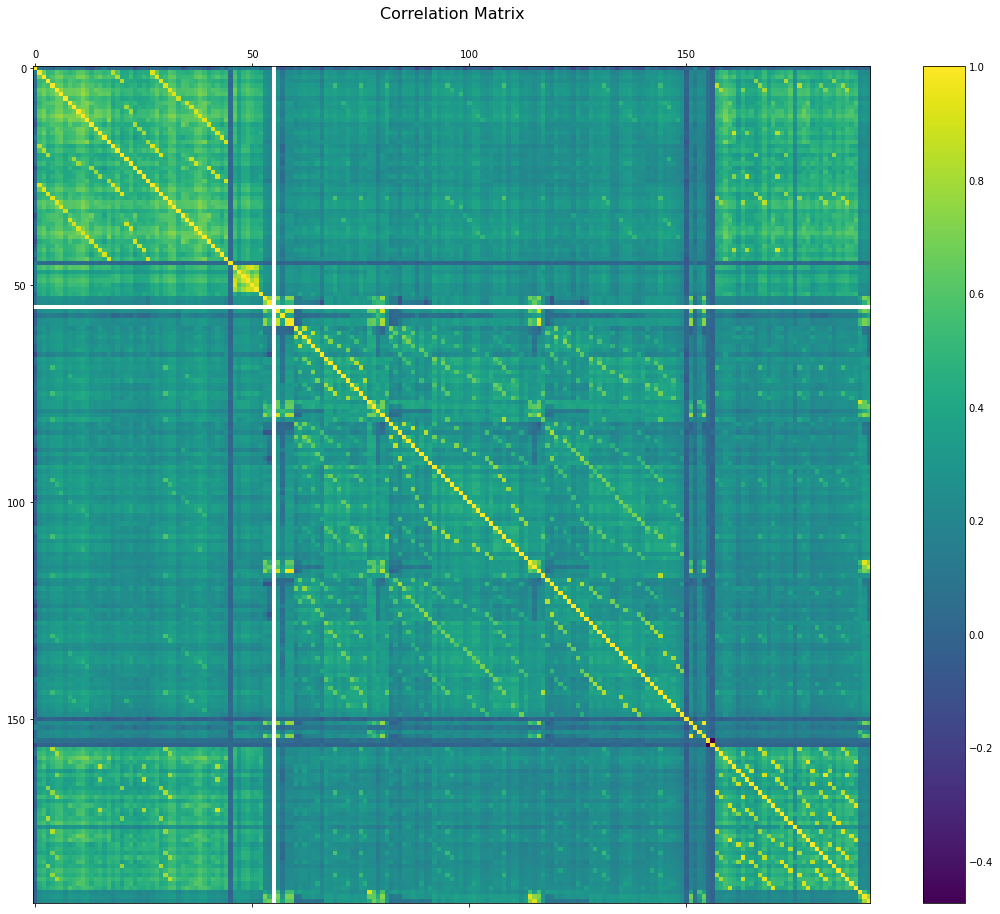

In [41]:
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.data.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title('Correlation Matrix', fontsize=16);

## Train/test split

- stratify by two columns: treatment and target. 

`Intuition:` In a binary classification problem definition we stratify train set by splitting target `0/1` column. In uplift modeling we have two columns instead of one. 

In [42]:
stratify_cols = pd.concat([dataset.treatment, dataset.target], axis=1)

X_train, X_val, trmnt_train, trmnt_val, y_train, y_val = train_test_split(
    dataset.data,
    dataset.treatment,
    dataset.target,
    stratify=stratify_cols,
    test_size=0.3,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

Train shape: (480920, 193)
Validation shape: (206109, 193)


## Pipeline with CatBoostClassifier

In [43]:
imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
estimator = CatBoostClassifier(verbose=100,
                               random_state=42,
                               thread_count=1)
ct_model = ClassTransformation(estimator=estimator)

my_pipeline = Pipeline([
    ('imputer', imp_mode),
    ('model', ct_model)
])

Usual fit pipeline but with aditional treatment parameter
`model__treatment = trmnt_train`.
    

In [44]:
my_pipeline = my_pipeline.fit(
    X=X_train, 
    y=y_train, 
    model__treatment=trmnt_train
)

Learning rate set to 0.143939
0:	learn: 0.6695107	total: 446ms	remaining: 7m 26s
100:	learn: 0.5950043	total: 34.4s	remaining: 5m 6s
200:	learn: 0.5908539	total: 1m 7s	remaining: 4m 29s
300:	learn: 0.5870115	total: 1m 41s	remaining: 3m 56s
400:	learn: 0.5835003	total: 2m 15s	remaining: 3m 22s
500:	learn: 0.5800551	total: 2m 48s	remaining: 2m 48s
600:	learn: 0.5768127	total: 3m 23s	remaining: 2m 15s
700:	learn: 0.5736896	total: 3m 58s	remaining: 1m 41s
800:	learn: 0.5706878	total: 4m 33s	remaining: 1m 7s
900:	learn: 0.5676374	total: 5m 7s	remaining: 33.8s
999:	learn: 0.5647908	total: 5m 43s	remaining: 0us


Predict uplift and calculate basic uplift metric **uplift@30%** at first 30%. Read more about the metric [in docs](https://www.uplift-modeling.com/en/latest/api/metrics/uplift_at_k.html).

In [45]:
uplift_predictions = my_pipeline.predict(X_val)

uplift_30 = uplift_at_k(y_val, uplift_predictions, trmnt_val, strategy='overall')
print(f'uplift@30%: {uplift_30:.4f}')

uplift@30%: 0.0504
